## 加载模型


In [1]:
import os
import json
import time
import web
import numpy as np
from PIL import Image
from config import *
from apphelper.image import union_rbox,adjust_box_to_origin,base64_to_PIL
from application import trainTicket,idcard 
if yoloTextFlag =='keras' or AngleModelFlag=='tf' or ocrFlag=='keras':
    if GPU:
        os.environ["CUDA_VISIBLE_DEVICES"] = str(GPUID)
        import tensorflow as tf
        from keras import backend as K
        config = tf.ConfigProto()
        config.gpu_options.allocator_type = 'BFC'
        config.gpu_options.per_process_gpu_memory_fraction = 0.3## GPU最大占用量
        config.gpu_options.allow_growth = True##GPU是否可动态增加
        K.set_session(tf.Session(config=config))
        K.get_session().run(tf.global_variables_initializer())
    
    else:
      ##CPU启动
      os.environ["CUDA_VISIBLE_DEVICES"] = ''

if yoloTextFlag=='opencv':
    scale,maxScale = IMGSIZE
    from text.opencv_dnn_detect import text_detect
elif yoloTextFlag=='darknet':
    scale,maxScale = IMGSIZE
    from text.darknet_detect import text_detect
elif yoloTextFlag=='keras':
    scale,maxScale = IMGSIZE[0],2048
    from text.keras_detect import  text_detect
else:
     print( "err,text engine in keras\opencv\darknet")
     
if DETECTANGLE:
    from text.opencv_dnn_detect import angle_detect
else:
    angle_detect = None

if ocr_redis:
    ##多任务并发识别
    from helper.redisbase import redisDataBase
    ocr = redisDataBase().put_values
else:   
    from crnn.keys import alphabetChinese,alphabetEnglish
    if ocrFlag=='keras':
        from crnn.network_keras import CRNN
        if chineseModel:
            alphabet = alphabetChinese
            if LSTMFLAG:
                ocrModel = ocrModelKerasLstm
            else:
                ocrModel = ocrModelKerasDense
        else:
            ocrModel = ocrModelKerasEng
            alphabet = alphabetEnglish
            LSTMFLAG = True
            
    elif ocrFlag=='torch':
        from crnn.network_torch import CRNN
        if chineseModel:
            alphabet = alphabetChinese
            if LSTMFLAG:
                ocrModel = ocrModelTorchLstm
            else:
                ocrModel = ocrModelTorchDense
                
        else:
            ocrModel = ocrModelTorchEng
            alphabet = alphabetEnglish
            LSTMFLAG = True
    elif ocrFlag=='opencv':
        from crnn.network_dnn import CRNN
        ocrModel = ocrModelOpencv
        alphabet = alphabetChinese
    else:
        print( "err,ocr engine in keras\opencv\darknet")
     
    nclass = len(alphabet)+1   
    if ocrFlag=='opencv':
        crnn = CRNN(alphabet=alphabet)
    else:
        crnn = CRNN( 32, 1, nclass, 256, leakyRelu=False,lstmFlag=LSTMFLAG,GPU=GPU,alphabet=alphabet)
    if os.path.exists(ocrModel):
        crnn.load_weights(ocrModel)
    else:
        print("download model or tranform model with tools!")
        
    ocr = crnn.predict_job
    
   
from main import TextOcrModel

model =  TextOcrModel(ocr,text_detect,angle_detect)
from apphelper.image import xy_rotate_box,box_rotate,solve


In [2]:
import cv2
import numpy as np

ft2 = cv2.freetype.createFreeType2()
ft2.loadFontData("/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc", 0)

def plot_box(img,boxes):
    blue = (0, 0, 0) #18
    tmp = np.copy(img)
    for box in boxes:
         cv2.rectangle(tmp, (int(box[0]),int(box[1])), (int(box[2]), int(box[3])), blue, 1) #19
    
    return Image.fromarray(tmp) 

def plot_boxes(img,angle, result,color=(0,0,0)):
    tmp = np.array(img)
    c = color
    h,w = img.shape[:2]
    thick = int((h + w) / 300)
    i = 0
    if angle in [90,270]:
        imgW,imgH = img.shape[:2]
        
    else:
        imgH,imgW= img.shape[:2]

    for line in result:
#         print('line:\n', line)
        cx =line['cx']
        cy = line['cy']
        degree =line['degree']
        w  = line['w']
        h = line['h']

        x1,y1,x2,y2,x3,y3,x4,y4 = xy_rotate_box(cx, cy, w, h, degree/180*np.pi)
        
        x1,y1,x2,y2,x3,y3,x4,y4 = box_rotate([x1,y1,x2,y2,x3,y3,x4,y4],angle=(360-angle)%360,imgH=imgH,imgW=imgW)
        cx  =np.mean([x1,x2,x3,x4])
        cy  = np.mean([y1,y2,y3,y4])
        cv2.line(tmp,(int(x1),int(y1)),(int(x2),int(y2)),c,1)
        cv2.line(tmp,(int(x2),int(y2)),(int(x3),int(y3)),c,1)
        cv2.line(tmp,(int(x3),int(y3)),(int(x4),int(y4)),c,1)
        cv2.line(tmp,(int(x4),int(y4)),(int(x1),int(y1)),c,1)
        mess=str(i)
        blurred_tmp = cv2.GaussianBlur(tmp,(3,3), 17)
        mask = np.zeros((imgH, imgW, 3), dtype=np.uint8)
        cv2.rectangle(mask, (int(x1), int(y1)), (int(x3), int(y3)),
                      color=(255, 255, 255), thickness=-1)
        tmp = np.where(mask==np.array([255, 255, 255]), blurred_tmp, tmp)
        ft2.putText(tmp, line['text'], (int(x1 + w * 0.1), int(y1)), fontHeight=int(h*0.9), color=(255, 51, 51), thickness=-1,
                    line_type=cv2.LINE_4, bottomLeftOrigin=False)
        # cv2.putText(tmp, line['text'], (int(cx), int(cy - 0.1 * h)), cv2.FONT_HERSHEY_SIMPLEX, h / 30, (255, 0, 0), 1, cv2.LINE_AA)
        i+=1
    return Image.fromarray(tmp).convert('RGB')


def plot_rboxes(img,boxes,color=(0,0,0)):
    tmp = np.array(img)
    c = color
    h,w = img.shape[:2]
    thick = int((h + w) / 300)
    i = 0


    for box in boxes:

        x1,y1,x2,y2,x3,y3,x4,y4 = box
        
        
        cx  =np.mean([x1,x2,x3,x4])
        cy  = np.mean([y1,y2,y3,y4])
        cv2.line(tmp,(int(x1),int(y1)),(int(x2),int(y2)),c,1)
        cv2.line(tmp,(int(x2),int(y2)),(int(x3),int(y3)),c,1)
        cv2.line(tmp,(int(x3),int(y3)),(int(x4),int(y4)),c,1)
        cv2.line(tmp,(int(x4),int(y4)),(int(x1),int(y1)),c,1)
        mess=str(i)
        cv2.putText(tmp, mess, (int(cx), int(cy)),0, 1e-3 * h, c, thick // 2)
        i+=1
    return Image.fromarray(tmp).convert('RGB')

********************************************************************** 
DEBUG: len(boxes): 1028 , scores: (1028,) , boxes: (1028, 4)
It take:1.6342227458953857s
用发票

用--------------发------票
相w0999国国g1发国发发发-发票8票票票飘
网u90一-用用国中国发国爱一龙成发P平P制制
间g81-g日日日国合日日日城成金家9干8飘关

湖北增独机安

湖----------------北--------增-------独------机----安
满jy,子jjjju08B日开北北水tStF国人增增堵1国国日日中-镇l发中中中发税C0,天-
-山国子j子子子子国l0PH北水水化l8F国日2的道详一8日国阳日中馆A家P千干机材发,一家专
断yu日''有||天1发日R王金金兆LAT日的大兴的灼4B口口国P不值a天日日华大横机.7安度

4200162130

4-----2--0--0-11-6--2--1--3--0---
292442-00O10O1--1062-21-1.-30-00)
1s95233196099.2568809--2210.7OG11
-n42美992G-.O6052.-078.24.3726o8.0

N0009989590998959

N---------0------0---0----9----9---8---9---5----9--0-9--9-8--9--5--9---
1h200wNNB0-010010O010O0219g989900189879-9759915950051095893808253190g.0
Mn022gTfPgo221.0GG337G2127-2272588933870119-52153161788158931093630-93m
0gC9yWfjgagG025CCo7012937221117-230071017233-7600386650637696-86-0H8a06

4200162130

4-----2---0----0--11---6---2---1---3----0--
199422-2.0O0000-01--116

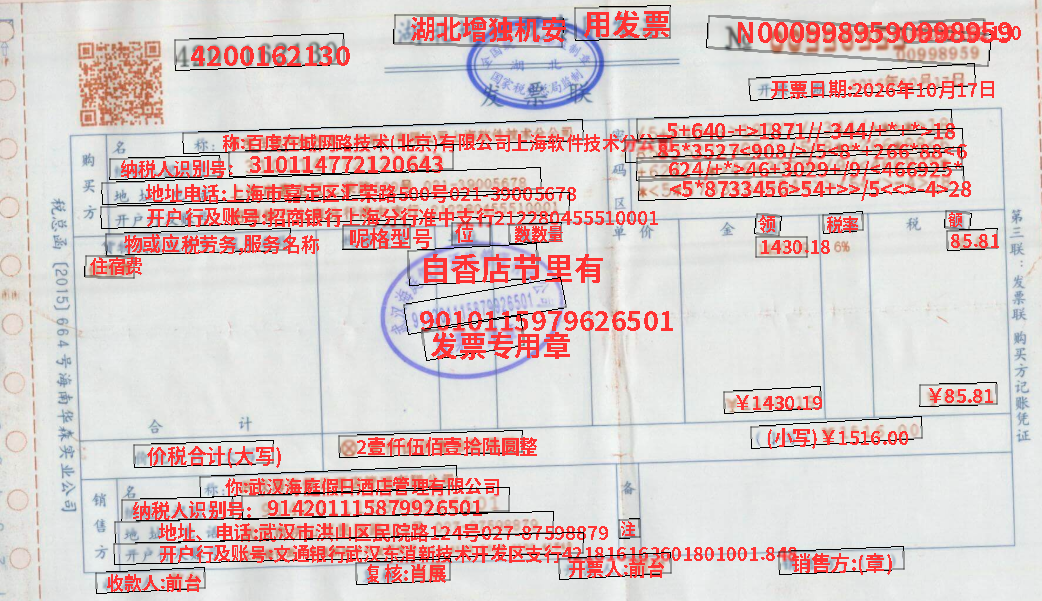

In [3]:
import time
from PIL import Image
import cv2

p = os.path.join('/amax/data/xiaowentao/Downloads/4506010211_Uy7k83z8Lk/dataset',
                 'ICPR 2018 MTWI网络图片文本检测数据集', 'image_9000',
                 'T111D_Xg4iXXXXXXXX_!!0-item_pic.jpg.jpg')
p = os.path.join('/amax/data/xiaowentao/chineseocr/test', 'test_1.png')
img = cv2.imread(p)

h,w = img.shape[:2]
timeTake = time.time()
scale=608
maxScale=2048

result, angle= model.model(img,
                        detectAngle=False,##是否进行文字方向检测
                        scale=scale,
                        maxScale=maxScale,
                        MAX_HORIZONTAL_GAP=20,##字符之间的最大间隔，用于文本行的合并
                        MIN_V_OVERLAPS=0.6,
                        MIN_SIZE_SIM=0.6,
                        TEXT_PROPOSALS_MIN_SCORE=0.1,
                        TEXT_PROPOSALS_NMS_THRESH=0.7,
                        TEXT_LINE_NMS_THRESH = 0.9,##文本行之间测iou值
                         LINE_MIN_SCORE=0.1,                                             
                        leftAdjustAlph=0,##对检测的文本行进行向左延伸
                        rightAdjustAlph=0.1,##对检测的文本行进行向右延伸
                        print_summary=True
                       )
        
timeTake = time.time()-timeTake

print('It take:{}s'.format(timeTake))
for line in result:
    print(line['text'])
    print(line['raw res'])
plot_boxes(img,angle, result,color=(0,0,0))

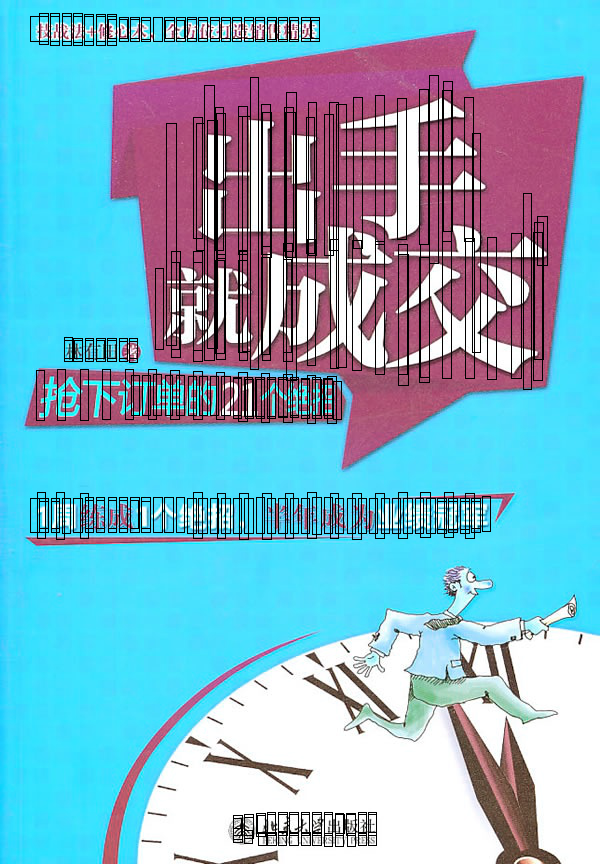

In [4]:
boxes,scores  = model.detect_box(np.array(img),608,2048)
plot_box(img,boxes)

In [5]:
"""Wrapper for various CTC decoders in SWIG."""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import swig_decoders


class Scorer(swig_decoders.Scorer):
    """Wrapper for Scorer.
    :param alpha: Parameter associated with language model. Don't use
                  language model when alpha = 0.
    :type alpha: float
    :param beta: Parameter associated with word count. Don't use word
                 count when beta = 0.
    :type beta: float
    :model_path: Path to load language model.
    :type model_path: basestring
    """

    def __init__(self, alpha, beta, model_path, vocabulary):
        swig_decoders.Scorer.__init__(self, alpha, beta, model_path, vocabulary)


def ctc_greedy_decoder(probs_seq, vocabulary):
    """Wrapper for ctc best path decoder in swig.
    :param probs_seq: 2-D list of probability distributions over each time
                      step, with each element being a list of normalized
                      probabilities over vocabulary and blank.
    :type probs_seq: 2-D list
    :param vocabulary: Vocabulary list.
    :type vocabulary: list
    :return: Decoding result string.
    :rtype: basestring
    """
    result = swig_decoders.ctc_greedy_decoder(probs_seq.tolist(), vocabulary)
    return result


def ctc_beam_search_decoder(probs_seq,
                            vocabulary,
                            beam_size,
                            cutoff_prob=1.0,
                            cutoff_top_n=40,
                            ext_scoring_func=None):
    """Wrapper for the CTC Beam Search Decoder.
    :param probs_seq: 2-D list of probability distributions over each time
                      step, with each element being a list of normalized
                      probabilities over vocabulary and blank.
    :type probs_seq: 2-D list
    :param vocabulary: Vocabulary list.
    :type vocabulary: list
    :param beam_size: Width for beam search.
    :type beam_size: int
    :param cutoff_prob: Cutoff probability in pruning,
                        default 1.0, no pruning.
    :type cutoff_prob: float
    :param cutoff_top_n: Cutoff number in pruning, only top cutoff_top_n
                         characters with highest probs in vocabulary will be
                         used in beam search, default 40.
    :type cutoff_top_n: int
    :param ext_scoring_func: External scoring function for
                             partially decoded sentence, e.g. word count
                             or language model.
    :type external_scoring_func: callable
    :return: List of tuples of log probability and sentence as decoding
             results, in descending order of the probability.
    :rtype: list
    """
    beam_results = swig_decoders.ctc_beam_search_decoder(
        probs_seq.tolist(), vocabulary, beam_size, cutoff_prob, cutoff_top_n,
        ext_scoring_func)
    beam_results = [(res[0], res[1]) for res in beam_results]
    return beam_results


def ctc_beam_search_decoder_batch(probs_split,
                                  vocabulary,
                                  beam_size,
                                  num_processes,
                                  cutoff_prob=1.0,
                                  cutoff_top_n=40,
                                  ext_scoring_func=None):
    """Wrapper for the batched CTC beam search decoder.
    :param probs_seq: 3-D list with each element as an instance of 2-D list
                      of probabilities used by ctc_beam_search_decoder().
    :type probs_seq: 3-D list
    :param vocabulary: Vocabulary list.
    :type vocabulary: list
    :param beam_size: Width for beam search.
    :type beam_size: int
    :param num_processes: Number of parallel processes.
    :type num_processes: int
    :param cutoff_prob: Cutoff probability in vocabulary pruning,
                        default 1.0, no pruning.
    :type cutoff_prob: float
    :param cutoff_top_n: Cutoff number in pruning, only top cutoff_top_n
                         characters with highest probs in vocabulary will be
                         used in beam search, default 40.
    :type cutoff_top_n: int
    :param num_processes: Number of parallel processes.
    :type num_processes: int
    :param ext_scoring_func: External scoring function for
                             partially decoded sentence, e.g. word count
                             or language model.
    :type external_scoring_function: callable
    :return: List of tuples of log probability and sentence as decoding
             results, in descending order of the probability.
    :rtype: list
    """
    # probs_split = [probs_seq.tolist() for probs_seq in probs_split]
    probs_split = probs_split.tolist()

    batch_beam_results = swig_decoders.ctc_beam_search_decoder_batch(
        probs_split, vocabulary, beam_size, num_processes, cutoff_prob,
        cutoff_top_n, ext_scoring_func)
    batch_beam_results = [
        [(res[0], res[1]) for res in beam_results]
        for beam_results in batch_beam_results
    ]
    return batch_beam_results

In [8]:
alphabet_list = [c for c in alphabet]
scorer = Scorer(alpha=1.0, beta=0.0, model_path='./models/zh_giga.no_cna_cmn.prune01244.klm',
                vocabulary=alphabet_list)

In [9]:
import time
from PIL import Image
from torch.nn.functional import softmax 
import os

# p = './test/test_1.png'
p = os.path.join('/amax/data/xiaowentao/Downloads/4506010211_Uy7k83z8Lk/dataset',
                 'ICPR 2018 MTWI网络图片文本检测数据集', 'image_9000',
                 'T10k40XfxoXXbqL6.9_074222.jpg.jpg')
img = cv2.imread(p)

h,w = img.shape[:2]
timeTake = time.time()
scale=608
maxScale=2048

result,angle= model.model(img,
                                    detectAngle=False,##是否进行文字方向检测
                                    scale=scale,
                                    maxScale=maxScale,
                                    MAX_HORIZONTAL_GAP=20,##字符之间的最大间隔，用于文本行的合并
                                    MIN_V_OVERLAPS=0.6,
                                    MIN_SIZE_SIM=0.6,
                                    TEXT_PROPOSALS_MIN_SCORE=0.1,
                                    TEXT_PROPOSALS_NMS_THRESH=0.7,
                                    TEXT_LINE_NMS_THRESH = 0.9,##文本行之间测iou值
                                     LINE_MIN_SCORE=0.1,                                             
                                    leftAdjustAlph=0,##对检测的文本行进行向左延伸
                                    rightAdjustAlph=0.1,##对检测的文本行进行向右延伸
                                   )
        
timeTake = time.time()-timeTake

print('It take:{}s'.format(timeTake))
for line in result:
    print('text:', line['text'], flush=True)
    print('raw res:', line['raw res'], flush=True)
#     print(line['raw preds'].shape, flush=True)
#     print(line['raw preds'][:, :5, :].topk(k=4, dim=2))
#     print('pred labels:', line['raw preds'].max(2)[1].view(-1))
    beam_search_results = ctc_beam_search_decoder_batch(
            probs_split=softmax(line['raw preds'], dim=2),
            vocabulary=alphabet_list,
            beam_size=50,
            num_processes=1,
            ext_scoring_func=scorer,
            cutoff_prob=1.0,
            cutoff_top_n=50)
    print('beam search results:', beam_search_results[0][:4], flush=True)
# plot_boxes(img,angle, result,color=(0,0,0))

********************************************************************** 
DEBUG: len(boxes): 281 , scores: (281,) , boxes: (281, 4)
It take:0.5449435710906982s
text: 热
raw res: 
热----
这有9数业
应人5热高
整hs国X

beam search results: [(-0.5048882961273193, ''), (1.0070059299468994, '这'), (1.42757248878479, '应'), (1.3164374828338623, '热')]
text: 050M州厚坐
raw res: 
0---------5--0--M------州-----厚-----坐--
Oh000D07.565CC1MHMSs的N州的l1mP日月一8国国生必:人
UmOgD0B116-.0-IHWH8a人m的加10WF人原15S日四尘1h
DgC999D00S97668W-m一S有h子如I数人人大具:35P业生国p

beam search results: [(2.393214464187622, '050M厚坐'), (7.066668510437012, '050厚坐'), (5.05538272857666, '05M厚坐'), (9.728889465332031, '05厚坐')]
text: 22可调喜低
raw res: 
2-----2------可-------调-----喜-----低
1合0022-0.S国F子万6一2a中中王遇188日高宫蒙1家日低街
四小220)8o088干于子5:im千口用温C22国一高复i国国人仍
3公o4)99e85中千开河中2大国年学理润金u国阳-其又有发8王何

beam search results: [(0.4937760829925537, '22子调喜低'), (0.7195465564727783, '22子调宫低'), (3.3443312644958496, '22年调喜低'), (4.357154846191406, '22调喜低')]
text: 
raw res: 
--------------------

In [68]:
!curl 'https://raw.githubusercontent.com/GitHub30/gdrive.sh/master/gdrive.sh' | env ALL_PROXY=socks5h://localhost:1080 bash -s 'https://drive.google.com/file/d/1jBPDcfe6JXwitFMWQ92UGODb58onJ2jh'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2874  100  2874    0     0   3154      0 --:--:-- --:--:-- --:--:--  3151
awk: warning: escape sequence `\?' treated as plain `?'
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3272    0  3272    0     0   9088      0 --:--:-- --:--:-- --:--:--  9088
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   1182      0 --:--:-- --:--:-- --:--:--  1182
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3923M    0 3923M    0     0  16.0M      0 --:--:--  0:04:04 --:--:-- 22

In [25]:
!cd '/amax/data/xiaowentao/Downloads/4506010211_Uy7k83z8Lk/dataset/ICPR 2018 MTWI网络图片文本检测数据集'/image_9000 && ls | head -n 10 && ls ../txt_9000 | head -n 10

T10k40XfxoXXbqL6.9_074222.jpg.jpg
T10o9DFaRXXXXXXXXX_!!0-item_pic.jpg.jpg
T10qIkFk8cXXXXXXXX_!!0-item_pic.jpg.jpg
T10vNfFzJdXXXXXXXX_!!0-item_pic.jpg.jpg
T10WUiFkdfXXXXXXXX_!!0-item_pic.jpg.jpg
T10yhFXthdXXXXXXXX_!!0-item_pic.jpg.jpg
T10zjcFF0bXXa5Rw33_050206.jpg.jpg
T111D_Xg4iXXXXXXXX_!!0-item_pic.jpg.jpg
T1138BFHpbXXXXXXXX_!!0-item_pic.jpg.jpg
T11748FhpcXXXXXXXX_!!0-item_pic.jpg.jpg
ls: write error: Broken pipe
T10k40XfxoXXbqL6.9_074222.jpg.txt
T10o9DFaRXXXXXXXXX_!!0-item_pic.jpg.txt
T10qIkFk8cXXXXXXXX_!!0-item_pic.jpg.txt
T10vNfFzJdXXXXXXXX_!!0-item_pic.jpg.txt
T10WUiFkdfXXXXXXXX_!!0-item_pic.jpg.txt
T10yhFXthdXXXXXXXX_!!0-item_pic.jpg.txt
T10zjcFF0bXXa5Rw33_050206.jpg.txt
T111D_Xg4iXXXXXXXX_!!0-item_pic.jpg.txt
T1138BFHpbXXXXXXXX_!!0-item_pic.jpg.txt
T11748FhpcXXXXXXXX_!!0-item_pic.jpg.txt
ls: write error: Broken pipe


In [35]:
import os
import json
import re
cnt = 0
cnt_re = 0
total = 0
base = '/amax/data/xiaowentao/Downloads/4506010211_Uy7k83z8Lk/dataset/ICPR 2018 MTWI网络图片文本检测数据集/txt_9000'
for f in os.listdir(base):
    with open(os.path.join(base, f)) as f:
        txt = f.readlines()
        total += len(txt)
        cnt += sum(['###' == t.split(',')[-1].strip() for t in txt])
        cnt_re += sum([re.match('^#+$', t.split(',')[-1].strip()) != None for t in txt])
print('cnt: ', cnt, 'cnt_re: ', cnt_re, 'total： ', total)

cnt:  49459 cnt_re:  49501 total：  177686


['1244.93,103.53,1224.33,793.47,1276.93,798.73,1275.93,105.53,###\n', '625.33,79.07,690.53,335.53,791.4,305.4,720.4,46.53,精品\n', '708.73,385.13,763.53,583.0,854.67,547.53,813.0,356.53,石磨\n', '237.93,222.2,577.27,1226.13,774.87,1163.8,485.2,145.87,六个土核桃\n', '118.27,336.07,268.73,813.8,293.6,803.13,150.13,328.53,石磨核桃饮品，采用古法石磨工艺，使核桃的营养成份更容易\n', '76.0,347.6,219.8,791.2,246.67,784.8,109.87,340.33,###\n', '689.87,368.07,637.93,386.0,679.33,528.07,729.27,509.87,升级版\n', '693.13,559.67,767.07,842.4,808.47,828.87,734.93,553.27,植物蛋白饮料\n', '148.53,308.47,269.47,660.33,315.67,652.4,207.73,293.4,新疆本土核桃\n', '288.67,715.8,395.33,1047.33,429.0,1037.67,339.0,703.73,好核桃更营养\n']


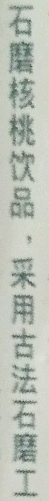

In [1]:
from apphelper.image import rotate_cut_img
from PIL import Image
import os
import cv2

# x1, y1 ~ x4, y4 为从左上角开始逆时针遍历
# 该数据集中看不清的数据用 ### 表示，而且我发现矩形框大小一般都偏小（字有一部分都漏出去了）
img = Image.open(os.path.join('/amax/data/xiaowentao/Downloads/4506010211_Uy7k83z8Lk/dataset',
                              'ICPR 2018 MTWI网络图片文本检测数据集', 'image_9000',
                              'TB1_qqfflTH8KJjy0Fi7cERsXXa.jpg'))
with open(os.path.join('/amax/data/xiaowentao/Downloads/4506010211_Uy7k83z8Lk/dataset',
                       'ICPR 2018 MTWI网络图片文本检测数据集', 'txt_9000',
                       'TB1_qqfflTH8KJjy0Fi7cERsXXa.txt')) as f:
    txt = f.readlines()
    
print(txt)
# plot_rboxes(np.array(img), [[float(i) for i in t.split(',')[:-1]] for t in txt[4:5]])
rotate_cut_img(img, [float(i) for i in txt[4].split(',')[:-1]])[0]

['4.95,51.79,16.95,105.79,121.62,53.45,96.95,1.79,热卖\n', '5.29,135.45,9.29,575.12,67.29,574.12,75.29,129.45,孕妇护士裤\n', '305.29,60.79,301.29,107.45,574.29,101.45,576.29,58.79,可调节松紧\n', '476.29,130.12,464.29,249.79,528.29,254.79,529.29,137.12,粉色\n', '477.29,308.45,466.29,431.79,521.95,438.12,528.95,298.12,蓝色\n', '555.62,211.45,546.62,335.45,600.95,332.45,603.95,204.45,白色\n', '695.62,424.12,703.29,467.12,785.95,468.45,786.95,428.79,限时\n', '707.62,478.79,702.29,549.45,762.95,552.12,782.29,473.79,折\n', '797.62,553.45,794.62,519.79,756.62,517.79,766.62,547.79,扣\n']


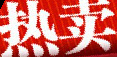

In [1]:
from apphelper.image import rotate_cut_img
from PIL import Image
import os
import cv2

# x1, y1 ~ x4, y4 为从左上角开始逆时针遍历
# 该数据集中看不清的数据用 ### 表示，而且我发现矩形框大小一般都偏小（字有一部分都漏出去了）
img = Image.open(os.path.join('/amax/data/xiaowentao/Downloads/4506010211_Uy7k83z8Lk/dataset',
                              'ICPR 2018 MTWI网络图片文本检测数据集', 'image_9000',
                              'T10o9DFaRXXXXXXXXX_!!0-item_pic.jpg.jpg'))
with open(os.path.join('/amax/data/xiaowentao/Downloads/4506010211_Uy7k83z8Lk/dataset',
                       'ICPR 2018 MTWI网络图片文本检测数据集', 'txt_9000',
                       'T10o9DFaRXXXXXXXXX_!!0-item_pic.jpg.txt')) as f:
    txt = f.readlines()
    
print(txt)
# plot_rboxes(np.array(img), [[float(i) for i in t.split(',')[:-1]] for t in txt])
rotate_cut_img(img, [float(i) for i in txt[0].split(',')[:-1]])[0]

10


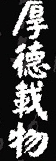

In [3]:
from apphelper.image import rotate_cut_img
from PIL import Image
import os
import cv2

# x1, y1 ~ x4, y4 为从左上角开始逆时针遍历
# 该数据集中看不清的数据用 ### 表示，而且我发现矩形框大小一般都偏小（字有一部分都漏出去了）
img = Image.open(os.path.join('/amax/data/xiaowentao/Downloads/4506010211_Uy7k83z8Lk/dataset',
                              'ICPR 2018 MTWI网络图片文本检测数据集', 'image_9000',
                              'TB1A.0naCfD8KJjSszhXXbIJFXa_!!0-item_pic.jpg.jpg'))
with open(os.path.join('/amax/data/xiaowentao/Downloads/4506010211_Uy7k83z8Lk/dataset',
                       'ICPR 2018 MTWI网络图片文本检测数据集', 'txt_9000',
                       'TB1A.0naCfD8KJjSszhXXbIJFXa_!!0-item_pic.jpg.txt')) as f:
    txt = f.readlines()
    
print(txt.index('491.93,355.27,456.49,510.94,419.38,508.39,457.49,352.27,厚德载物\n'))
# plot_rboxes(np.array(img), [[float(i) for i in t.split(',')[:-1]] for t in txt[10:11]])
rotate_cut_img(img, [float(i) for i in txt[10].split(',')[:-1]])[0]

In [1]:
import h5py
import os
from time import time
from apphelper.image import rotate_cut_img
import numpy as np
import re
from PIL import Image

base = '/amax/data/xiaowentao/Downloads/4506010211_Uy7k83z8Lk/dataset/ICPR 2018 MTWI网络图片文本检测数据集'
cnt, cnt_bad = 0, 0
print('start')
s_t = time()

# 依然有个人识别出错旋转角度的框，大概 100 个
with h5py.File("/data/xiaowentao/chineseocr/dataset/ICPR_2018_MTWI_STR.hdf5", "w") as f:
    for f_img in os.listdir(os.path.join(base, 'image_9000')):
        img = Image.open(os.path.join(base, 'image_9000', f_img))
        with open(os.path.join(base, 'txt_9000', f_img[:-4] + '.txt')) as f_txt:
            txt = f_txt.readlines()
            for idx, box in enumerate(txt):
                text = box.split(',')[-1].strip()
                if not re.match('^#+$', text):
                    cnt += 1
                    box_location = [float(i) for i in box.split(',')[:-1]]
                    res = rotate_cut_img(img, box_location)
                    if abs(np.tan(res[1]['degree'] / 180 * np.pi)) > 1.732:
                        print('cnt:', cnt, ', res:', res[1], f_img, idx, box_location)
                    assert res[0].size[1] > 0 and res[0].size[0] > 0, 'src:' + f_img + '/' + str(idx) + ', txt: ' + text + ', box' + str(box_location)
                    f[str(cnt) + '/' + 'img'] = np.array(res[0])
                    f[str(cnt) + '/' + 'txt'] = text
                    f[str(cnt) + '/' + 'box'] = np.array(box_location)
                    f[str(cnt) + '/' + 'src'] = 'image_9000/' + f_img + '/' + str(idx)
                    f[str(cnt) + '/' + 'vertical'] = res[2]
                    if cnt % 2500 == 0:
                        print('sample processed:', cnt, ', time:', time() - s_t)
                else:
                    cnt_bad += 1
print('cnt:', cnt, 'cnt_bad:', cnt_bad, 'time:', time() - s_t)
!ls -alh "/data/xiaowentao/chineseocr/dataset/ICPR_2018_MTWI_STR.hdf5"

start
Unexpected tanA!!!!
cnt: 381 , res: {'cx': 79.0675, 'cy': 661.375, 'w': 133.73574690410936, 'h': 76.93666226188907, 'degree': 63.338124615111354} T13JrlXcXmXXbvwaw._110954.jpg.jpg 3 [14.63, 618.75, 80.88, 732.25, 136.63, 708.75, 84.13, 585.75]
sample processed: 2500 , time: 8.940566778182983
sample processed: 5000 , time: 18.244467973709106
Unexpected tanA!!!!
cnt: 6213 , res: {'cx': 567.6925, 'cy': 173.25, 'w': 16.733937074101732, 'h': 11.437487704911462, 'degree': -61.445267479534095} TB10KxLLXXXXXaUXpXXunYpLFXX.jpg 53 [573.75, 170.09, 567.61, 179.32, 562.48, 176.91, 566.93, 166.68]
Unexpected tanA!!!!
cnt: 7301 , res: {'cx': 580.7475000000001, 'cy': 473.08500000000004, 'w': 81.59404941538332, 'h': 19.14183964513336, 'degree': -60.763554969008084} TB11gROLXXXXXXbXpXXunYpLFXX.jpg 7 [595.33, 434.0, 606.0, 441.0, 565.33, 511.67, 556.33, 505.67]
Unexpected tanA!!!!
cnt: 7458 , res: {'cx': 360.76750000000004, 'cy': 354.5375, 'w': 20.187509133124877, 'h': 11.855097005086009, 'degree'

sample processed: 47500 , time: 192.32027578353882
sample processed: 50000 , time: 202.71171140670776
Unexpected tanA!!!!
cnt: 51131 , res: {'cx': 293.1675, 'cy': 514.8074999999999, 'w': 49.64874419358455, 'h': 37.5299880095904, 'degree': -65.12623246577843} TB1j2XJLXXXXXcsXpXXunYpLFXX.jpg 11 [289.67, 494.89, 275.33, 527.89, 293.0, 540.56, 314.67, 495.89]
sample processed: 52500 , time: 212.36034607887268
Unexpected tanA!!!!
cnt: 54607 , res: {'cx': 558.0799999999999, 'cy': 272.9525, 'w': 76.61890758814047, 'h': 37.47892507796894, 'degree': 60.26203269763869} TB1kBOObfBNTKJjSszeXXcu2VXa_!!0-item_pic.jpg.jpg 18 [531.71, 246.33, 563.52, 305.67, 588.33, 302.71, 548.76, 237.1]
Unexpected tanA!!!!
cnt: 54961 , res: {'cx': 439.46, 'cy': 183.19500000000002, 'w': 34.884982442305954, 'h': 19.39500000000004, 'degree': -72.67662085277217} TB1kFNCLXXXXXbiXFXXunYpLFXX.jpg 8 [436.15, 173.08, 433.69, 192.62, 438.92, 194.0, 449.08, 173.08]
sample processed: 55000 , time: 222.3603756427765
Unexpected t

Unexpected tanA!!!!
cnt: 87496 , res: {'cx': 719.5, 'cy': 253.75, 'w': 56.43580423808976, 'h': 28.65745976181418, 'degree': -66.03751102542182} TB1w.hmcN6I8KJjSszfXXaZVXXa_!!0-item_pic.jpg.jpg 2 [715.5, 285.0, 701.5, 272.0, 729.5, 223.0, 731.5, 235.0]
sample processed: 87500 , time: 355.6318156719208
Unexpected tanA!!!!
cnt: 88918 , res: {'cx': 282.835, 'cy': 322.09499999999997, 'w': 15.482804978426884, 'h': 9.447487761304615, 'degree': -60.98585493349922} TB1wHc0n9fD8KJjSszhXXbIJFXa_!!0-item_pic.jpg.jpg 20 [278.44, 324.96, 282.21, 316.81, 288.13, 318.96, 282.56, 327.65]
sample processed: 90000 , time: 365.1290202140808
Unexpected tanA!!!!
cnt: 91222 , res: {'cx': 641.83, 'cy': 277.05, 'w': 39.11521443121592, 'h': 23.717082451262854, 'degree': 62.40270413135629} TB1xB33oSfD8KJjSszhXXbIJFXa_!!2-item_pic.png.jpg 6 [628.58, 268.55, 642.58, 290.55, 652.58, 285.55, 643.58, 263.55]
Unexpected tanA!!!!
cnt: 92089 , res: {'cx': 520.985, 'cy': 341.4825, 'w': 26.411665036494696, 'h': 12.90007848

sample processed: 120000 , time: 494.0773720741272
sample processed: 122500 , time: 504.7206172943115
Unexpected tanA!!!!
cnt: 123030 , res: {'cx': 851.1975, 'cy': 537.77, 'w': 56.95384644604792, 'h': 40.30020161239895, 'degree': -64.61864942643389} TB2Qle1dsbI8KJjy1zdXXbe1VXa_!!546185834.jpg.jpg 17 [836.71, 547.82, 849.91, 560.97, 870.11, 528.82, 848.06, 513.47]
Unexpected tanA!!!!
cnt: 123035 , res: {'cx': 545.0225, 'cy': 337.895, 'w': 96.02162516850052, 'h': 54.26238337928032, 'degree': -62.42573237147374} TB2Qle1dsbI8KJjy1zdXXbe1VXa_!!546185834.jpg.jpg 22 [506.36, 372.97, 539.61, 387.22, 580.26, 301.87, 553.86, 289.52]
Unexpected tanA!!!!
cnt: 123143 , res: {'cx': 81.3175, 'cy': 483.0675, 'w': 84.75331556936283, 'h': 28.212156954050897, 'degree': 61.89435791992662} TB2Qo8bwSFmpuFjSZFrXXayOXXa_!!3284731990.jpg.jpg 40 [103.09, 510.09, 72.09, 446.36, 53.91, 451.18, 96.18, 524.64]
Unexpected tanA!!!!
cnt: 124111 , res: {'cx': 409.9675, 'cy': 227.0925, 'w': 33.92935012640237, 'h': 17.32

128185
Y
['38.5,23.0,40.5,41.0,314.5,39.0,314.5,25.0,技战法+修心术，全方位打造销售精英\n', '203.5,137.0,185.5,256.0,481.5,251.0,491.5,96.0,出手\n', '170.5,245.0,177.5,370.0,534.5,380.0,556.5,202.0,就成交\n', '69.5,341.0,65.5,360.0,140.5,363.0,139.5,342.0,林有田著\n', '42.5,377.0,34.5,422.0,339.5,421.0,333.5,387.0,抢下订单的21个绝活\n', '36.5,505.0,34.5,533.0,491.5,531.0,490.5,504.0,1周练成1个绝招，半年成为业绩冠军\n', '264.5,815.0,258.5,836.0,375.5,835.0,375.5,821.0,北京大学出版社\n', '262.5,837.0,261.5,846.0,377.5,845.0,377.5,837.0,###\n', '197.5,742.0,198.5,798.0,318.5,795.0,318.5,771.0,X\n', '301.5,672.0,351.5,740.0,404.5,732.0,380.5,661.0,XI\n', '445.5,640.0,454.5,703.0,521.5,702.0,527.5,636.0,XII\n']


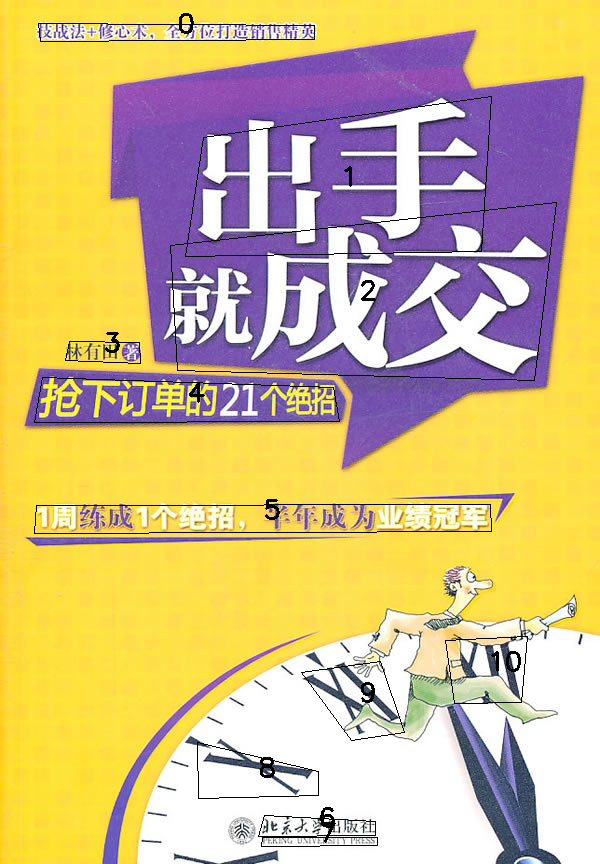

In [4]:
import h5py
from PIL import Image

with h5py.File('/data/xiaowentao/chineseocr/dataset/ICPR_2018_MTWI_STR.hdf5', 'r') as f:
    print(len(f['.']))
    img = Image.fromarray(f['75825/img'][...]).convert('RGB')
    print(f['75825/txt'][...])
img_all = Image.open(os.path.join('/amax/data/xiaowentao/Downloads/4506010211_Uy7k83z8Lk/dataset',
                              'ICPR 2018 MTWI网络图片文本检测数据集', 'image_9000',
                              'T111D_Xg4iXXXXXXXX_!!0-item_pic.jpg.jpg'))
txt = open(os.path.join('/amax/data/xiaowentao/Downloads/4506010211_Uy7k83z8Lk/dataset',
                              'ICPR 2018 MTWI网络图片文本检测数据集', 'txt_9000',
                              'T111D_Xg4iXXXXXXXX_!!0-item_pic.jpg.txt')).readlines()
# img
print(txt)
plot_rboxes(np.array(img_all), [[float(i) for i in t.split(',')[:-1]] for t in txt])

In [5]:
!nvidia-smi

Thu Mar 26 20:07:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.14       Driver Version: 430.14       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:18:00.0  On |                  N/A |
| 22%   22C    P8    13W / 250W |     51MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:3B:00.0  On |                  N/A |
| 22%   23C    P8    10W / 250W |     27MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G